# UPDATE THIS Run Test 3.30.23
- 9 days (465 x 9 x 7000= 29M total FFTs, 2^24, 660MHz clock) 
- switch antenna and term (switch=1 is terminator. 1/16 duty cycle) 
- 4dB fixed attenuation, pasternack 1012 to mini circuits zkl1r5+ (9V regulated from battery). 
- Run started 4-19-23 at 16:19:15. 
- Right at clipping

In [60]:
import sys 
import numpy as np
#import settings as s
import matplotlib.pyplot as plt 
import importlib
#importlib.reload(s)
from cupyx.profiler import benchmark
import h5py
import os
import re
import time
import datetime
from datetime import datetime
import pandas as pd
import math

sys.path.insert(0, '../../../drlib')
import drlib as dr
%matplotlib widget

def mad_np(arr):
    median = np.median(arr)
    return np.median(np.abs(arr-median))

def freq2Idx(freq, freqsAll):
    return int(freq/freqsAll[-1] * len(freqsAll))

def idx2freq(idx, freqs):
    return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]

dataDir         = '/drBigBoy/darkRadio/daqAnalysisAndExperiments/run1p4/overnight_antennaRun_5_2_23/'
filename        = 'spec_gitignore.npy'





In [40]:
#Average and save spectra

avgAntSpec = np.load(dataDir + filename, allow_pickle=True).item()["chBSpec_W"]
avgVetoSpec = np.load(dataDir + filename, allow_pickle=True).item()["chASpec_W"]




def avgSpecFromPacked(avgIdxs, specStr):
    sum = np.zeros(2**23+1)
    for i in avgIdxs:
        sum += f[specStr][:,i]
    avgSpec = sum/(len(avgIdxs))
    return avgSpec

def rollingMadLim(spec,
    nSigma = 1,
    order = 1,
    fc_numBins = 100
):
    specFiltered = dr.filterSpec(spec, fc_numBins=fc_numBins, order=order)
    window = 1000

    rollingMadArr = dr.rolling(specFiltered, window, 1, mad_np, numProc=48)

    filter_fc           = 30 * window
    filteredMadArr  = dr.filterSpec(rollingMadArr, order = 2, fc_numBins = filter_fc, type = 'lowpass')
    diffFilterMadPadArr = dr.nanPad(filteredMadArr, window)
    rollMadLim      = diffFilterMadPadArr * nSigma * 1.48
    return rollMadLim, specFiltered, nSigma, order, fc_numBins

#Average, filter and save
if 1:

    #filter/rolling mad limit and save
    antRollingMadLim, antFilt, Sigma, order, fc_numBins     = rollingMadLim(avgAntSpec)

    #np.save(f'./avgSpecs_gitignore/antRollingMadLim_W_12p6e6FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_4_24_23', antRollingMadLim)
    #np.save(f'./avgSpecs_gitignore/termRollingMadLim_W_8e5FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_4_24_23', termRollingMadLim)

    #np.save(f'./avgSpecs_gitignore/antFilt_W_12e6FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_4_24_23', antFilt)
    #np.save(f'./avgSpecs_gitignore/termFilt_W_8e5FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_4_24_23', termFilt)



done mp


Text(0.5, 0, 'Freqency (MHz)')

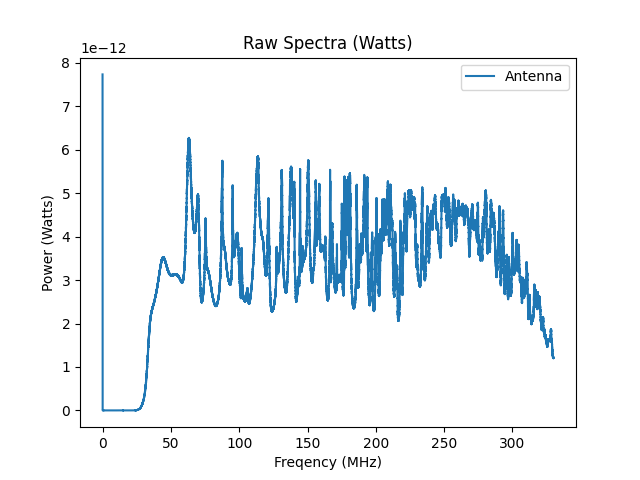

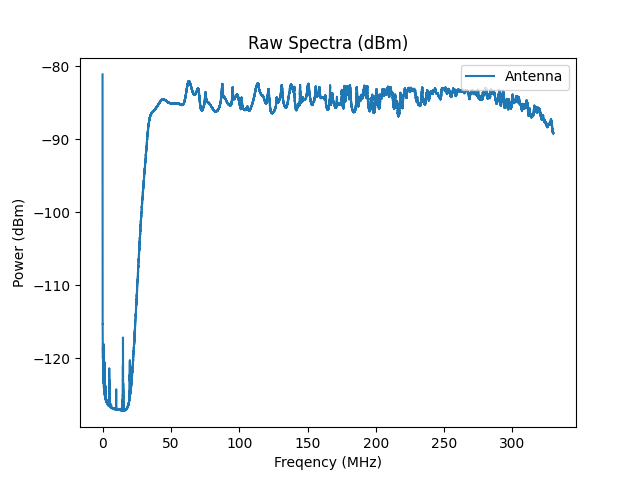

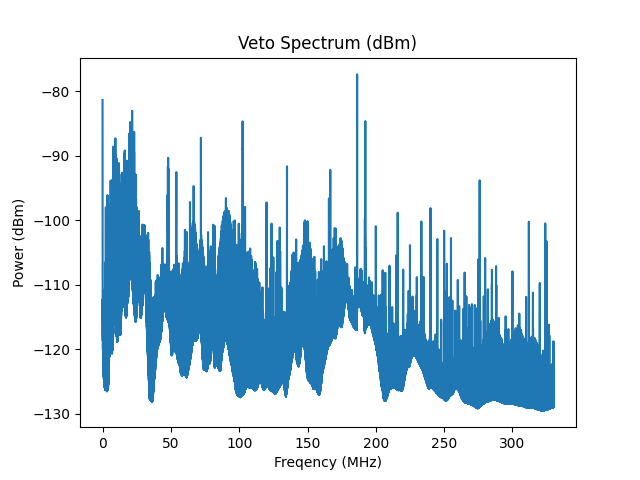

In [41]:
#load files generated in previous cell
# only saved nSigma=1, changing nSigma just multplies the rolling mad limit in this cell

order       = 1
fc_numBins  = 100

#plot raw spectra
freqs       = np.linspace(0, 330e6, 2**23, dtype=np.float64)

plt.close('all')

plt.title('Raw Spectra (Watts)')
plt.plot(freqs/1e6, avgAntSpec[1:], label = 'Antenna')
plt.ylabel('Power (Watts)')
plt.xlabel('Freqency (MHz)')
plt.legend(loc = 'upper right')

plt.figure()
plt.title('Raw Spectra (dBm)')
plt.plot(freqs/1e6, 10*np.log10(avgAntSpec[1:]*1000), label = 'Antenna')
plt.ylabel('Power (dBm)')
plt.xlabel('Freqency (MHz)')
plt.legend(loc = 'upper right')

plt.figure()
plt.title('Veto Spectrum (dBm)')
plt.plot(freqs/1e6, 10*np.log10(avgVetoSpec[1:]*1000))
plt.ylabel('Power (dBm)')
plt.xlabel('Freqency (MHz)')



6609205 antenna candidates
Expected 6609205.993479439 candidates at -6 sigma


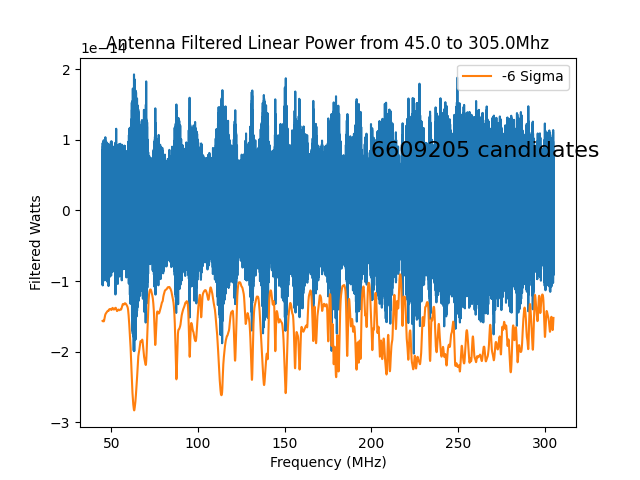

In [146]:

nSigma = -6

pltFreqStart    = 45e6
pltFreqStop     = 305e6
pltIdxStart     = freq2Idx(pltFreqStart, freqs)
pltIdxStop      = freq2Idx(pltFreqStop, freqs)
numBins         = pltIdxStop - pltIdxStart
expectedCans    = (1 - math.erf(nSigma/np.sqrt(2)) ) * numBins /2

antCanList_idx = ((antFilt > nSigma * antRollingMadLim)) 
antCandidateTotal = (antCanList_idx[pltIdxStart:pltIdxStop].sum())
print(f"{antCandidateTotal} antenna candidates")
print(f"Expected {expectedCans} candidates at {nSigma} sigma")

plt.close('all')

plt.figure()
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, antFilt[pltIdxStart:pltIdxStop])
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6,(nSigma * antRollingMadLim)[pltIdxStart:pltIdxStop], label = f'{nSigma} Sigma')
plt.text(200,.75e-14, f'{antCandidateTotal} candidates',size=16)
plt.title(f"Antenna Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Watts')
plt.legend(loc='upper right')


if 0:
    plt.figure()
    plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, antFilt[pltIdxStart:pltIdxStop], label = 'Antenna')
    plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtTermSpec[pltIdxStart:pltIdxStop], label = 'Terminator', alpha = .5)
    plt.text(200,.75e-14, f'{termCandidateTotal} candidates',size=16)
    plt.title(f"Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Filtered Watts')
    plt.legend(loc = 'upper right')

fit mean: -0.00023715733818762875
fit sigma: 0.9984915783349831


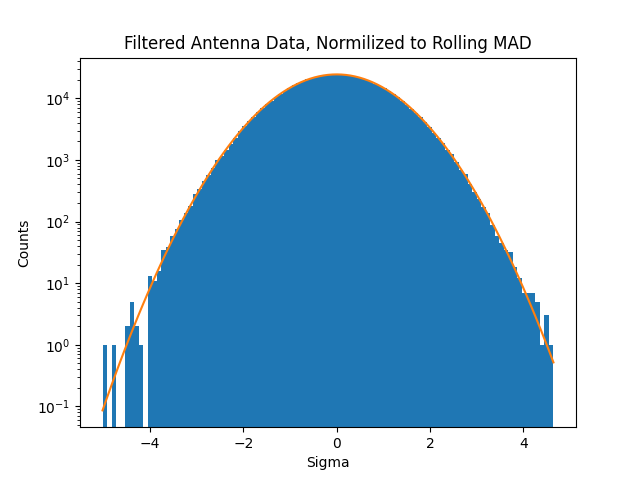

In [143]:
from scipy.stats import normaltest
from scipy.optimize import curve_fit

def gaus(x, a, mu, sigma):
    return a * np.exp(-((x-mu)**2)/2*sigma)

bins            = 100

normAntSpec     = (antFilt/antRollingMadLim)[pltIdxStart:pltIdxStop]

histY, histX    = np.histogram(normAntSpec, bins = bins)

# Compute bin centers
bin_centers = histX[:-1] + np.diff(histX) / 2


popt, pcov      = curve_fit(gaus, bin_centers, histY, p0=[10**4, 0, 1])

print(f"fit mean: {popt[1]}")
print(f"fit sigma: {popt[2]}")

plt.close('all')
plt.title("Filtered Antenna Data, Normilized to Rolling MAD")
plt.hist(normAntSpec, bins=bins, log=True)
plt.plot(histX, gaus(histX, popt[0], popt[1], popt[2]), label = f'Gaussian Fit. mu={round(popt[1],5)}, sigma={round(popt[2], 5)}')
plt.xlabel('Sigma')
plt.ylabel('Counts')
plt.show()
plt.legend()

In [ ]:
#generate lists of candidates

antCanIdx   = (np.where(antCanList_idx  == True))[0]
termCanIdx  = (np.where(termCanList_idx == True))[0]

antMask     = (antCanIdx >= pltIdxStart) & (antCanIdx <= pltIdxStop)
termMask    = (termCanIdx >= pltIdxStart) & (termCanIdx <= pltIdxStop)

antCanIdx   = antCanIdx[antMask]
termCanIdx  = termCanIdx[termMask]

antCanFreqs =np.asarray([idx2freq(idx,freqs) for idx in antCanIdx])
termCanFreqs=np.asarray([idx2freq(idx,freqs) for idx in termCanIdx])



print(len(antCanFreqs), 'antenna candidates')
#print('at freqs. ', antCanFreqs/1e6)
print(len(termCanFreqs), 'terminator candidates')
print('at freqs. ', termCanFreqs/1e6)

In [ ]:
def consolidateCandidates(rawCanList, freqs, stepsize=1):
    '''
    Takes array of indices of candidates and returns a data frame
    with one row per candidate and columns with the candidate frequency,
    number of bins wide and the starting index of that candidate
    Inputs:
        rawCanList (1D list or np array): list of indices of candidates
        reqs (1D list or np array): list of frequencies
        stepsize: should be 1 to find adjecent candidates
    Calls:
        idx2Freq()
    '''
    rawCanList = np.asarray(rawCanList)
    splitList =  np.split(rawCanList, np.where(np.diff(rawCanList) > stepsize)[0]+1)
    canList = [can[0] for can in splitList]
    canListFreq =  [idx2freq(can[0],freqs) for can in splitList]
    canLenList = [len(can) for can in splitList]
    candidate_df = pd.DataFrame()
    candidate_df['canFreq_Mhz'] = [freq/1e6 for freq in canListFreq]
    candidate_df['numBins'] = canLenList
    candidate_df['idx'] = canList
    #candidate_df['idx absolute'] = [idx + idxStart for idx in canList]
    diffArr = np.zeros(len(canList))
    diffArr[0] =  float('nan')
    diffArr[1:] = np.diff(canList)
    candidate_df['deltaIdx'] = diffArr
    candidate_df['deltaFreq_Hz'] = [deltaIdx* (s.SAMPLE_RATE) /s.CH0_RECORD_LEN for deltaIdx in diffArr]

    return candidate_df

stepsize = 10
candidate_df = consolidateCandidates(antCanIdx, freqs, stepsize=stepsize)
#candidate_df.to_csv(f'./candidateListCsvs/candidateList_run1_firstThird_diffGreaterThan10Bins_{nSigma}sigma_fc100bins_Order1_4_24_23.csv')
candidate_df

In [ ]:

fig, ax = plt.subplots()

ax.plot(np.arange(0, len(freqs), 1), np.zeros(len(freqs)), alpha = 0)
ax.set_xlabel('bin number')
ax.xaxis.tick_top()
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.xaxis.set_ticks_position('top')
ax.set_xlim(pltIdxStart, pltIdxStop)
ax.set_ylim(np.min(filtAntSpec[pltIdxStart:pltIdxStop]), 
    np.max(filtAntSpec[pltIdxStart:pltIdxStop]*1.05)
)
ax.set_ylabel('Linear Power')

ax2 = ax.twiny()

ax2.plot(freqs/1e6, filtAntSpec[1:])
ax2.plot(freqs/1e6,  antRollingMadLim[1:], label = f'{nSigma} sigma (rolling mad)')
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Linear Power (W)')


#ax2.plot(np.arange(pltIdxStart, pltIdxStop, 1), antRollingMadLim[pltIdxStart:pltIdxStop], 'orange', label = '5 sigma (rolling mad)')
ax2.scatter(freqs[candidate_df['idx']]/1e6, antRollingMadLim[candidate_df['idx']], color ='r', marker = 'x')
ax2.set_xlim(pltFreqStart/1e6, pltFreqStop/1e6)
#ax2.set_ylim(np.min(filtAntSpec[pltIdxStart:pltIdxStop]), 
#    np.max(filtAntSpec[pltIdxStart:pltIdxStop])
#)

ax2.legend(loc = 'upper right')
ax2.xaxis.tick_top()

plt.show()

print('stepsize = %i ' %stepsize)
print('butter filter (order = %i and' %order, 'f_c = %i'  %fc_numBins, 'bins)')

print('number of candidates = ', len(candidate_df['idx']) )

In [ ]:
#create a list of bunches of spurs
print()
idxDiff = np.diff(antCanIdx)
#print(idxDiff)
diffMask = np.where(idxDiff == 1, True, False)
diffMask = np.append(False, diffMask,)

onesIdxs = antCanIdx[diffMask]
#print(freqs[onesIdxs])

hist, binEdges = np.histogram(idxDiff, bins = 10000, range=(1,10001))
#print(binEdges)
histNoZeros = []
binsNoZeros = []
for i, val in enumerate(hist):
    if val != 0 and val != 1:
        histNoZeros.append(val)
        binsNoZeros.append(binEdges[i])
binsNoZeros =[str(int(bin)) for bin in binsNoZeros]

count = 0
for val in idxDiff:
    if int(val) > 10000:
        count += 1
print("Count of differences greater than 10000: ", count)


plt.close('all')
plt.figure()
#plt.semilogy()
plt.scatter(np.arange(0, len(idxDiff), 1),(idxDiff))
plt.title('Difference Between Adjacent Candidates')
plt.xlabel('Index Within Candidate List')
plt.ylabel('Difference')
plt.grid()
plt.tight_layout()

#hist without skipping empty bins. Not useful
if 0:
    plt.figure();
    plt.hist(idxDiff, bins = 10000, range=(2,10002));
    plt.title('Difference Between Adjacent Candidates')
    plt.xlabel('Difference')
    plt.ylabel('Counts')

#hist skipping unused bins
plt.figure();
plt.bar(binsNoZeros, histNoZeros);
plt.title('Difference Between Adjacent Candidates');
plt.xlabel('Difference');
plt.ylabel('Counts');
plt.xticks(rotation='vertical');
plt.tight_layout()
plt.grid()

In [ ]:
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler, FigureWidgetResampler

x = freqs[pltIdxStart:pltIdxStop]
main_data = filtAntSpec[pltIdxStart:pltIdxStop]
sigmaLine = antRollingMadLim[pltIdxStart:pltIdxStop]
veto_data = avgVetoSpec[pltIdxStart:pltIdxStop]

# Create the subplots with shared x-axis
fig = FigureWidgetResampler(make_subplots(rows=2, cols=1, shared_xaxes=True),  default_n_shown_samples=10000)

# Add the main data trace to the first subplot
fig.add_trace(
    go.Scattergl(
        x=x,
        y=main_data,
        mode='lines',
        marker=dict(
            color='blue',
            size=1
        ),
        name='Main Channel, filtered Watts'
    ),
    row=1, col=1
)

# Add the sigma limit trace to the first subplot
fig.add_trace(
    go.Scattergl(
        x=x,
        y=sigmaLine,
        mode='lines',
        marker=dict(
            color='orange',
            size=1
        ),
        name='6 sigma limit'
    ),
    row=1, col=1
)
 #add an x where main channel power goes over 6 sigma
fig.add_trace(go.Scatter(
    x=freqs[candidate_df['idx']],
    y=antRollingMadLim[candidate_df['idx']],
    mode='markers',
    marker=dict(color='red', symbol='x'),
    name = 'Main power > 6 sigma'
))
 

# Add the veto data trace to the second subplot
fig.add_trace(
    go.Scattergl(
        x=x,
        y=10 * np.log10(veto_data * 1000),
        #y = veto_data,
        mode='lines',
        marker=dict(
            color='red',
            size=1
        ),
        name='Veto Channel'
    ),
    row=2, col=1
)

# Set the subplot titles and axis labels
fig.update_layout(
    title='Main and Veto Channels',
    xaxis_title='Frequency (MHz)',
    yaxis_title='Filtered Main Channel (Watts)',
    yaxis2_title='Veto (dBm)',
    yaxis=dict(exponentformat='power')
)

# Wrap the figure with FigureWidgetRescaler for resampling
#resampler = FigureWidgetRescaler(fig)

# Display the resampled figure
#resampler.widget()
